## Cargar librerías y datos

In [226]:
%matplotlib inline      
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_validate, KFold, cross_val_score, train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from patsy import dmatrices
import time
sns.set_style('whitegrid')     ###quizas comentar esta parte

## Preparar datos

In [234]:
ventanadetiempo=250    #se usaran input muestras para fitear el modelo
ventana_historia_hacia_atras=203  #Cuantos dias hacia atras hacer la simulacion  #notar que se entregaran el input+1 fairvalues
dias_a_predecir=30  # cambiar nombre
dt=1    # 
ventana_tiempo_media_movil=20             #separar inputs de la parte de cargar datos  #enfatizar en que momento se hace el ventana_tiempo_media_movil 
df=pd.read_excel("Data_CLP_BBG.xlsx",sheet_name=1)
df = df[df.columns.drop(list(df.filter(regex='Index.1')))]
df.drop_duplicates()
df=df.interpolate()                 #Interpolate missing values
df=df.dropna(axis=0)
df=df.dropna().reset_index(drop=True)
df=df.iloc[::dt, :]     
df.reset_index(drop=True,inplace=True)
df=df.set_index("Dates")
returns = df.pct_change() 
dflog = np.log(1+returns)
dflog=dflog.add_suffix(" log_returns")
dflog=dflog.interpolate()
dflog=dflog.dropna(axis=0)
dfma=df.rolling(ventana_tiempo_media_movil).mean()
dfma=dfma.add_suffix(" Media_móvil_{}_días".format(ventana_tiempo_media_movil))
df_delta=df.diff(periods=1)

## Regresiones

## Outliers

In [235]:
sigmas_para_outliers=3  #cambiar nombre quizas
newdf_log=dflog[(dflog < dflog.mean()+sigmas_para_outliers*dflog.std()) & (dflog > dflog.mean()-sigmas_para_outliers*dflog.std())]
newdf_log=newdf_log.interpolate()
mask=(dflog > dflog.mean()+sigmas_para_outliers*dflog.std()) | (dflog < dflog.mean()-sigmas_para_outliers*dflog.std())
mask.columns=list(df.columns.values)
newdf=df.iloc[1:,:].mask(mask)
newdf=pd.concat([pd.DataFrame(df.iloc[0,:]).transpose(),newdf])
newdf=newdf.interpolate()
newdf_log.iloc[0,:]=dflog.iloc[0,:]    #Esto es por si queda un nan en el primer valor , para no perder informacion,luego se interpola
newdf_log.interpolate()
dflog_new=newdf_log
df_new=newdf

### Elegir target y features

In [236]:
target="CLP Curncy"  #Elegir target         #unir los dos dataframes
features=['MXN Curncy', 'BRL Curncy', 'EUR Curncy']    # ver esta parte
features.append(target)
dftest=df_new.loc[:,features]
dftest=dftest.reindex(columns=list(dftest.columns)[list(dftest.columns).index(target)+1:] +list(dftest.columns)[:list(dftest.columns).index(target)+1])
variables_log=[i + " log_returns" for i in features]
dflog_test=dflog_new.loc[:,variables_log]
dflog_test=dflog_test.reindex(columns=list(dflog_test.columns)[list(dflog_test.columns).index(target+" log_returns")+1:] +list(dflog_test.columns)[:list(dflog_test.columns).index(target+" log_returns")+1])
features.pop(-1)

'CLP Curncy'

## Gráficos Target

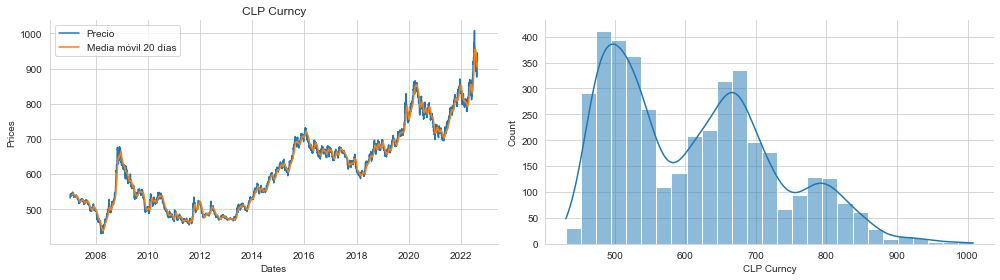

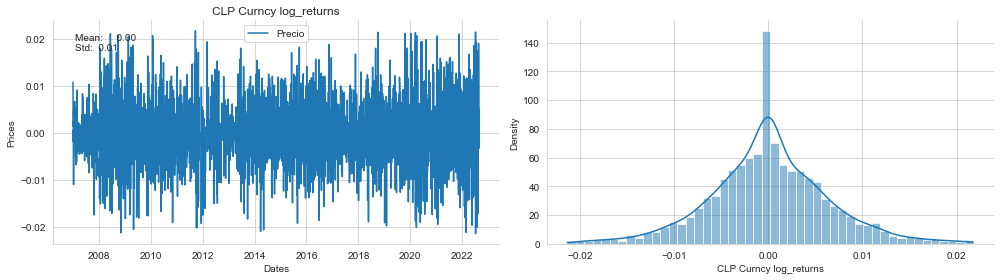

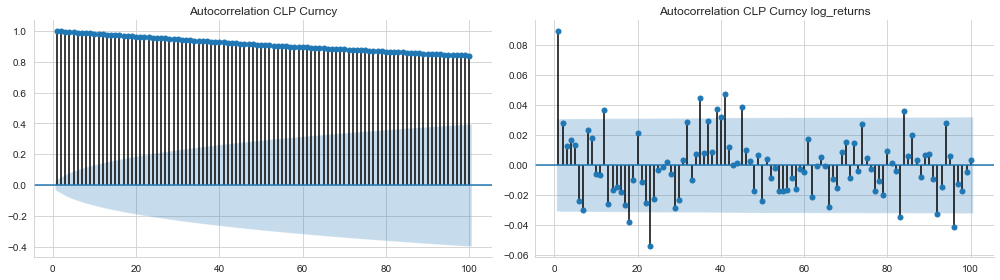

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
sns.histplot(dftest.loc[:,target],ax=ax2,kde=True)
ax1.set_title(target)
ax1.plot(dftest.index, dftest.loc[:,target],label="Precio")
ax1.plot(dfma.index,dfma.loc[:,target+" Media_móvil_{}_días".format(ventana_tiempo_media_movil)],label="Media móvil {} días".format(ventana_tiempo_media_movil))
ax1.legend()
ax1.set_xlabel('Dates')
ax1.set_ylabel('Prices')
sns.despine()
fig.tight_layout();

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
sns.histplot(dflog_test.loc[:,target+" log_returns"],ax=ax2,kde=True,stat="density")
ax1.text(x=.05, y=.9,s=f'Mean: {dflog_test.loc[:,target+" log_returns"].mean():8.2f}\nStd: {dflog_test.loc[:,target+" log_returns"].std():5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax1.transAxes)

ax1.set_title(target+" log_returns")
ax1.plot(dflog_test.index, dflog_test.loc[:,target+" log_returns"],label="Precio")
ax1.legend()
ax1.set_xlabel('Dates')
ax1.set_ylabel('Prices')
sns.despine()
fig.tight_layout();

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
plot_acf(df[target],ax=ax1, lags=100, zero=False, title='Autocorrelation {}'.format(target))
plot_acf(dflog_test[target+" log_returns"].dropna(),ax=ax2, lags=100, zero=False, title='Autocorrelation {}'.format(target+" log_returns"))
sns.despine()
fig.tight_layout();

<AxesSubplot:title={'center':' Correlaciones CLP Curncy'}>

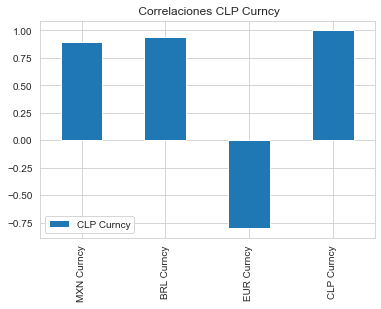

In [132]:
pd.DataFrame(dftest.corr().loc[target]).plot.bar(title=f" Correlaciones {target}")

In [252]:
dftest=dflog_test
target=target+" log_returns"     #arreglar esto

### Esta parte si se quiere hacer un pca antes 

In [138]:
nc=len(features)
X=dftest.iloc[:,:-1]
std_scaler = StandardScaler()          
std_scaler.fit(X)
x_media=X.mean()    
x_std=X.std()
X=std_scaler.transform(X)
X=pd.DataFrame(X)
pca= decomposition.PCA(n_components=nc)
pca.fit((X))
valores=pca.transform((X))
X_pca=pd.DataFrame(valores)
X_pca.index=dftest.index
dftest_pca=pd.concat([X_pca,dftest.iloc[:,-1]], axis=1)
pca_componentes=pd.DataFrame(pca.components_)
X_pca.columns=[" vector "+ str(i+1) for i in range(0,pca_componentes.shape[0])]
pca_componentes.columns=features
pca_componentes.index=[" vector "+ str(i+1) for i in range(0,pca_componentes.shape[0])]
dftest_pca

,0,1,2,CLP Curncy log_returns
Dates,,,,
2007-01-03,-1.341427,0.943226,-0.040104,0.010835
2007-01-04,-1.411015,0.636106,-0.549382,0.005540
2007-01-05,-1.083853,0.735273,0.050861,0.001422
2007-01-08,0.105148,-0.319676,-0.204760,0.002451
2007-01-09,-0.503975,0.138290,-0.544921,-0.001842
...,...,...,...,...
2022-08-18,-1.501170,1.185332,-0.553483,0.017630
2022-08-19,-0.718226,0.679415,-0.209310,0.016177
2022-08-22,-0.591873,1.716795,0.096661,-0.003255


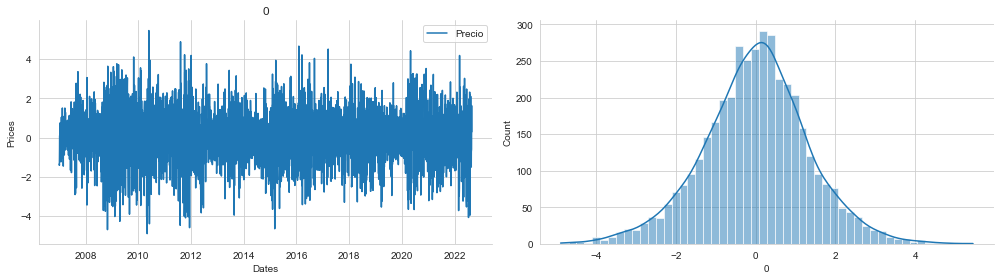

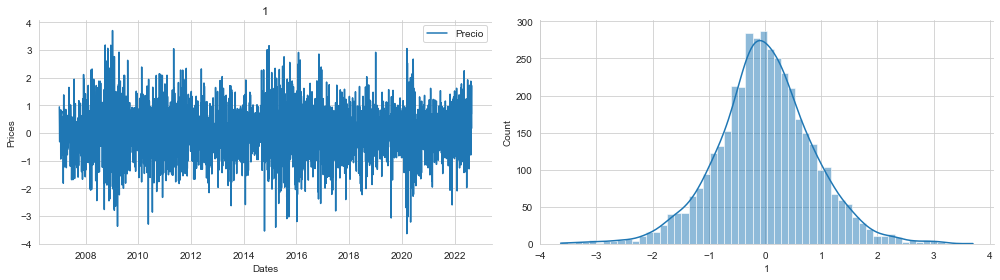

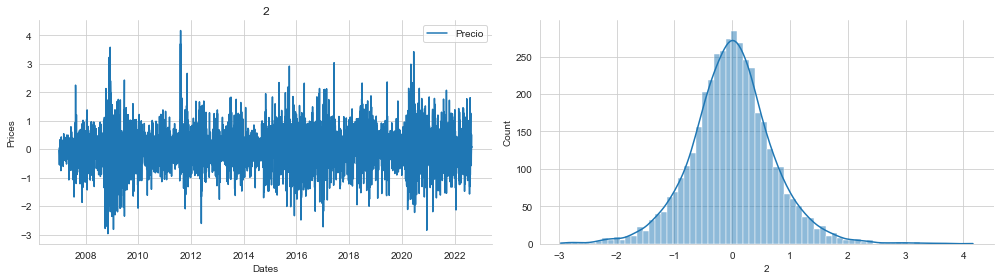

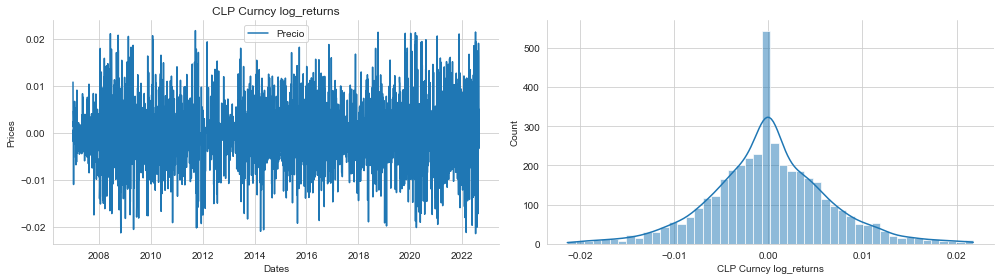

In [319]:
for i,v in enumerate(dftest_pca):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
        sns.histplot(dftest_pca.iloc[:,i],ax=ax2,kde=True)
#          corregir dos cosas , que se giren los nombres del eje x y normalizar grafico
        ax1.set_title(v)
        ax1.plot(dftest_pca.index, dftest_pca.iloc[:,i],label="Precio")
        ax1.legend()
        ax1.set_xlabel('Dates')
        ax1.set_ylabel('Prices')
        sns.despine()
        fig.tight_layout();

,Explained Variance,Cumulative Variance
vector 1,0.578611,0.579
vector 2,0.249419,0.828
vector 3,0.171970,1.000


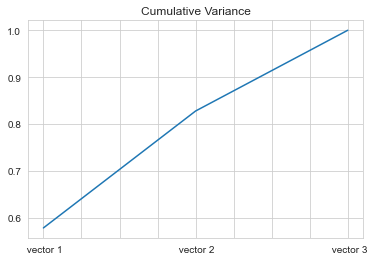

In [140]:
explained_variance=pca.explained_variance_ratio_
explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([ explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance.drop(0,axis=0,inplace=False)

df_explained_variance.index=[" vector "+ str(i) for i in range(0,df_explained_variance.shape[0])]
df_explained_variance.iloc[1:,1].plot(title="Cumulative Variance")
df_explained_variance.iloc[1:,:]


## Componentes PCA

<AxesSubplot:>

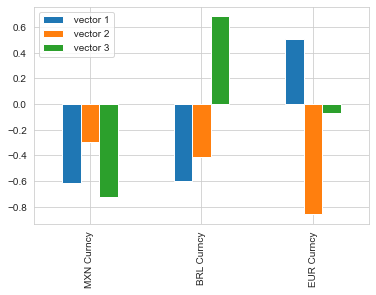

In [141]:
pca_componentes.transpose().plot(rot=90,kind="bar")

# Definición funciones regresiones lineales

In [237]:
def train_test_split(X,Y,dias_a_predecir,ventanadetiempo,dias_atras):
    if dias_atras<dias_a_predecir:
        x_train=X.iloc[dias_atras+1:ventanadetiempo+dias_atras+1]
        x_test=X.iloc[:dias_atras+1]
        y_train=Y.iloc[dias_atras+1:ventanadetiempo+dias_atras+1]        
        y_test=Y.iloc[:dias_atras+1]
    else:
        x_train=X.iloc[dias_a_predecir::]
        x_test=X.iloc[:dias_a_predecir]
        y_train=Y.iloc[dias_a_predecir::]        
        y_test=Y.iloc[:dias_a_predecir]
    return(x_train,x_test,y_train,y_test)

In [238]:
def reglineal(x_train,x_test,y_train,y_test,modelo_de_regresion):
    pipe=Pipeline(steps=[('scaler', StandardScaler()),])
    x_train=pd.DataFrame(pipe.fit_transform(x_train))
    x_test=pd.DataFrame(pipe.transform(x_test))
    #valores_x_actuales=pd.DataFrame(x_test.iloc[-1]).transpose()   
    valor_y_actual=y_test.iloc[-1]
    reg_lineal = modelo_de_regresion.fit(x_train, y_train) 
    try:
        coeficientes_reg_lineal=pd.DataFrame(reg_lineal.coef_)
    except AttributeError:
        coeficientes_reg_lineal=pd.DataFrame(reg_lineal.feature_importances_)
    valores_predichos=reg_lineal.predict(x_test)                     #PRIMERA PARTE ESTA BIEN, QUIZAS HACER UN PIPELINE
    reg_lineal_score_test_R2=r2_score(y_test,valores_predichos)      # VER LO DE LA ESTANDARIZACION DE LOS TEST SET Y TODO ESO
    reg_lineal_score_train_R2=r2_score(y_train,reg_lineal.predict(x_train))     #VER COMO PASAR LOS DATOS AFUERA DE LA FUNCION, QUIZAS UN DATAFRAME
    reg_lineal_score_train_RMSE=mean_squared_error(y_train,reg_lineal.predict(x_train),squared=False)
    reg_lineal_score_test_RMSE= mean_squared_error(y_test,valores_predichos,squared=False)
    errores_R2=np.array([reg_lineal_score_train_R2,reg_lineal_score_test_R2])
    errores_RMSE=np.array([reg_lineal_score_train_RMSE,reg_lineal_score_test_RMSE])
    fairvalue_actual=valores_predichos[-1]  
    return(fairvalue_actual,coeficientes_reg_lineal,errores_RMSE,errores_R2,reg_lineal,valor_y_actual)

In [239]:
def reglineal_summary(x_train,y_train,modelo_de_regresion):
    lista_features=list(x_train.columns.values)
    pipe=Pipeline(steps=[('scaler', StandardScaler()),])
    x_train=pd.DataFrame(pipe.fit_transform(x_train))
    x_train.columns=lista_features
    x_train.index=y_train.index
    model = OLS(endog=y_train, exog=add_constant(x_train))       #Tratar de que el summary dependa de "modelo_de_regresion"    trained_model = model.fit()
    trained_model = model.fit()
    summary=trained_model.summary()
    return(summary)

In [240]:
def iterar_fair_value_reg_lineal(dftest,ventanadetiempo,ventana_historia_hacia_atras,modelo_de_regresion):
    lista_fair_values=[]
    df_coeficientes=pd.DataFrame()
    lista_errores_RMSE_train=[]
    lista_errores_R2_train=[]
    lista_errores_RMSE_test=[]
    lista_errores_R2_test=[]
    lista_fit_modelo=[]
    f=[]
    g=[]
    X=dftest.iloc[:,:-1]
    Y=dftest.iloc[:,-1]
    lista_features=list(X.columns.values)
    for i in range(ventana_historia_hacia_atras+1):
        if i<dias_a_predecir:
            train_test_set=train_test_split(X.iloc[::-1].iloc[:ventanadetiempo+dias_a_predecir],Y.iloc[::-1].iloc[:ventanadetiempo+dias_a_predecir],dias_a_predecir,ventanadetiempo,i)
            datos_modelo=reglineal(train_test_set[0],train_test_set[1],train_test_set[2],train_test_set[3],modelo_de_regresion)
            if i==0:
                summary=reglineal_summary(train_test_set[0],train_test_set[2],modelo_de_regresion)
            else:
                i=i
        else:
            train_test_set=(train_test_split(X.iloc[::-1].iloc[i-dias_a_predecir+1:ventanadetiempo+i+1],Y.iloc[::-1].iloc[i-dias_a_predecir+1:ventanadetiempo+i+1],dias_a_predecir,ventanadetiempo,i))
            datos_modelo=reglineal(train_test_set[0],train_test_set[1],train_test_set[2],train_test_set[3],modelo_de_regresion)
        lista_fair_values.append(datos_modelo[0])
        df_coeficientes=df_coeficientes.append(datos_modelo[1].transpose()) 
        lista_errores_RMSE_train.append(datos_modelo[2][0])
        lista_errores_R2_train.append(datos_modelo[3][0])
        lista_errores_RMSE_test.append(datos_modelo[2][1])
        lista_errores_R2_test.append(datos_modelo[3][1])
        lista_fit_modelo.append(datos_modelo[4])       #cambiar nombres a variables 
        f.append(datos_modelo[5])
    df_coeficientes.columns=lista_features
    df_coeficientes=df_coeficientes.iloc[::-1]
    df_coeficientes.index=dftest.iloc[-ventana_historia_hacia_atras-1:,:].index
    df_fair_values=pd.DataFrame(lista_fair_values)
    df_fair_values.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index
    data={"RSE_train":lista_errores_RMSE_train,"RSE_test":lista_errores_RMSE_test,"R2_train":lista_errores_R2_train,"R2_test":lista_errores_R2_test}
    df_errores=pd.DataFrame(data=data)
    df_errores.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index       #aca dar vuelta df_errores quizas
    return(df_fair_values,df_coeficientes,df_errores,lista_fit_modelo,f,summary)

In [241]:
def grafico_fair_value_vs_valor_actual(dftest,df_fair_values,ventana_historia_hacia_atras,ventanadetiempo,target):  # Aca el target esta en la ultima columna del dataframe
    std_hist_df=desv_estandar_historica_target(dftest,ventana_historia_hacia_atras,ventanadetiempo,target)
    values=dftest.iloc[-df_fair_values.shape[0]:,-1]
    df_values=values.to_frame()
    df_fair_value_valor_actual=pd.concat([df_values,df_fair_values], axis=1)
    df_fair_value_valor_actual.columns.values[1]=target+" Predict"
    delta=df_fair_value_valor_actual[target]-df_fair_value_valor_actual[target+" Predict"]
    df_fair_value_valor_actual["Delta"]=delta
    fig, ax =plt.subplots(1,1)   
    data=[[dftest.iloc[-1,-1],df_fair_value_valor_actual.iloc[-1,1],df_fair_value_valor_actual.iloc[-1,-1]]]
    column_labels=["Valor actual", "Fair Value Actual", "Delta"]
    ax.axis('tight')
    ax.axis('off')
    table=ax.table(cellText=data,colLabels=column_labels,loc="center left")
    table.scale(2, 4)
    table.set_fontsize(32)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))
    fig.suptitle("Fairvalue y valor actual ")
    ax2.plot(df_fair_value_valor_actual.index, df_fair_value_valor_actual["Delta"])
    ax1.plot(df_fair_value_valor_actual.index, df_fair_value_valor_actual[target+" Predict"],label=target+" Predict")
    ax1.plot(df_fair_value_valor_actual.index, df_fair_value_valor_actual[target],label=target)
    ax1.fill_between(std_hist_df.index,-std_hist_df.iloc[:,0]+df_fair_value_valor_actual[target] , std_hist_df.iloc[:,0]+df_fair_value_valor_actual[target], color='green', alpha=.2)
    ax1.legend(loc="upper right")
    ax1.tick_params(labelrotation=90)     
    ax2.tick_params(labelrotation=90)
    ax1.set_title('Fair Value v/s valor realizado')
    ax2.set_title('Delta')
    ax2.text(x=.05, y=.9,s=f"Correlation: {df_fair_value_valor_actual.corr().iloc[0,1]:5.2f}",transform=ax2.transAxes)
    sns.despine()
    plt.show()
    #fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    ax1=sns.histplot(df_fair_value_valor_actual.loc[:,"Delta"],kde=True)
    ax2=sns.jointplot(x=target, y=target+" Predict",robust=True, ci=None,line_kws={'lw': 1, 'color': 'k'},scatter_kws={'s': 1},data=df_fair_value_valor_actual,kind='reg') 
    delta_std=df_fair_value_valor_actual["Delta"].std()
    delta_media=df_fair_value_valor_actual["Delta"].mean()
    ax1.text(x=.05, y=.9,s=f'Media: {delta_media:8.2f}\nStd: {delta_std:5.2f}',horizontalalignment='left',verticalalignment='center',transform=ax1.transAxes)
    f = plt.figure()
    sns.despine()
    plt.show()
    return(df_fair_value_valor_actual)

In [242]:
def desv_estandar_historica_target(dftest,ventana_historia_hacia_atras,ventanadetiempo,target):
    target_df=dftest.loc[:,target]
    std_hist_df=target_df.rolling(ventanadetiempo).std()
    std_hist_df=pd.DataFrame(std_hist_df.iloc[-ventana_historia_hacia_atras-1:])
    std_hist_df=std_hist_df.rename(columns={target:"Desv Estandar historica "+target})
    return((std_hist_df))

In [243]:
def grafico_coeficientes(df_coeficientes):
    df_coeficientes=df_coeficientes.div(abs(df_coeficientes).sum(axis=1), axis=0)*100
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))
    fig.suptitle('Coeficientes')
    ax2.plot=(df_coeficientes.iloc[-1,:]).plot.bar()
    ax1.plot(df_coeficientes.index,df_coeficientes.iloc[:,:])
    ax1.legend((list(df_coeficientes.columns.values)),loc="upper right")
    ax1.tick_params(labelrotation=90)            #hacer que fechas se vean en otro formato 
    ax2.tick_params(labelrotation=90) 
    ax1.set_title('Coeficientes en el tiempo')
    ax2.set_title('Coeficientes actualmente')
    sns.despine()
    plt.show()

In [244]:
def grafico_error_RMSE_R2(dftest,df_errores,ventanadetiempo,dias_a_predecir):
    n=(ventanadetiempo)
    p=dftest.shape[1]
    df_errores.iloc[:,2:]=df_errores.iloc[:,2:].apply(lambda x: (1-(1-x)*(n-1)/(n-p-1))) # Adjusted R2  
    fig, (plot_RMSE, plot_adjusted_R2) = plt.subplots(1, 2,figsize=(15, 7))
    fig.suptitle('Errores')
    plot_adjusted_R2.plot(df_errores.index,df_errores.iloc[:,2:],label={"Error Train","Error Test"})
    plot_RMSE.plot(df_errores.index,df_errores.iloc[:,0:2])
    
    plot_RMSE.tick_params(labelrotation=90)         #hacer que fechas se vean en otro formato 
    plot_adjusted_R2.tick_params(labelrotation=90)
    plot_RMSE.set_title(' Error RSE')
    plot_RMSE.legend(list(df_errores.iloc[:,0:2].columns.values),loc="upper right")
    plot_adjusted_R2.legend(list(df_errores.iloc[:,2:].columns.values),loc="upper right")
    plot_adjusted_R2.set_title(' Error Adjusted_R2')
    plot_RMSE.axvline(x =df_errores.index[dias_a_predecir] , color = 'r',linestyle="--", label = 'axvline - full height')
    plot_adjusted_R2.axvline(x = df_errores.index[dias_a_predecir] , color = 'r',linestyle="--", label = 'axvline - full height')
    sns.despine()
    plt.show()

# Regresión lineal

In [269]:
modelo_de_regresion=GradientBoostingRegressor(random_state=0)
#LinearRegression(),LassoCV(max_iter=10000),RidgeCV(),ElasticNetCV(max_iter=10000),RandomForestRegressor(n_estimators = 4, random_state = 42),SVR(kernel="linear",C=1.0, epsilon=0.2),GradientBoostingRegressor(random_state=0)

In [266]:
modelo_de_regresion=RandomForestRegressor(n_estimators = 10, random_state = 42)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


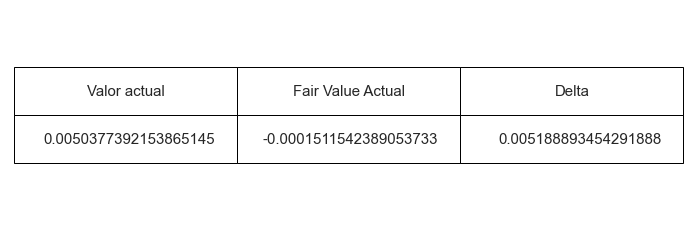

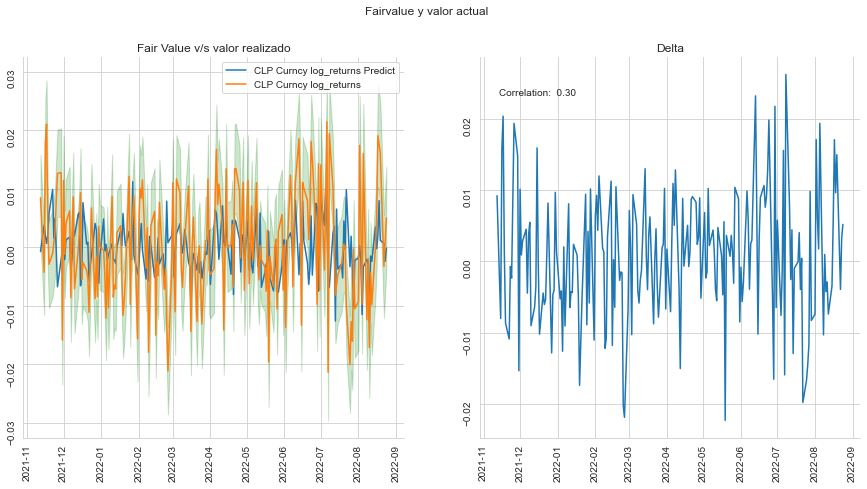

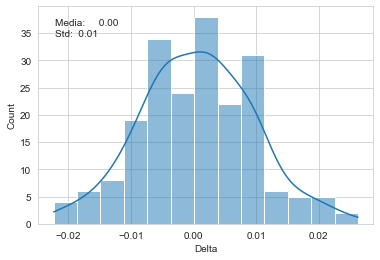

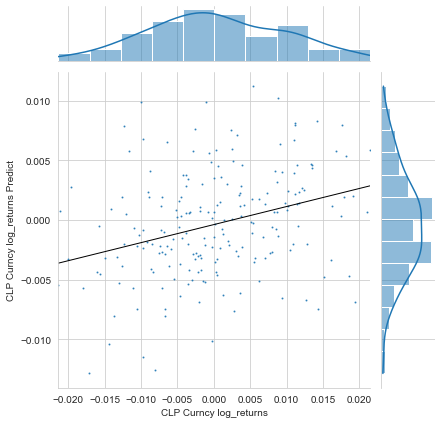

<Figure size 432x288 with 0 Axes>

<ipython-input-270-c182d3365496>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fair["valores"]=pd.DataFrame(dftest.iloc[-fair_value_en_ventana_tiempo[0].shape[0]:,-1])
<ipython-input-270-c182d3365496>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fair["Delta"]=df_fair.iloc[:,1]-df_fair.iloc[:,0]


In [270]:
fair_value_en_ventana_tiempo=iterar_fair_value_reg_lineal(dftest,ventanadetiempo,ventana_historia_hacia_atras,modelo_de_regresion)
df_fair_values=fair_value_en_ventana_tiempo[0]
df_fair_value_valor_actual=grafico_fair_value_vs_valor_actual(dftest,df_fair_values,ventana_historia_hacia_atras,ventanadetiempo,target)
h_r=0
diff_lgr=df_fair_value_valor_actual.diff()
for i in range(0,df_fair_value_valor_actual.shape[0]):
    if diff_lgr.iloc[i,0]>0 and diff_lgr.iloc[i,1]>0:
        h_r+=1
    elif diff_lgr.iloc[i,0]<0 and diff_lgr.iloc[i,1]<0:
        h_r+=1
    else:
        h_r=h_r
h_r=(h_r/(df_fair_value_valor_actual.shape[0]-1))
df_fair=fair_value_en_ventana_tiempo[0].iloc[::-1]
df_fair["valores"]=pd.DataFrame(dftest.iloc[-fair_value_en_ventana_tiempo[0].shape[0]:,-1])
df_fair["Delta"]=df_fair.iloc[:,1]-df_fair.iloc[:,0]
df_resultados=pd.DataFrame(fair_value_en_ventana_tiempo[2].mean())
df_resultados.index+=" mean"
df_resultados_std=pd.DataFrame(fair_value_en_ventana_tiempo[2].std())
df_resultados_std.index+=" std"
df_resultados1=pd.DataFrame(data=[abs(df_fair.iloc[:,2]).mean(),abs(df_fair.iloc[:,2]).std(),df_fair.iloc[:,2].mean(),df_fair.iloc[:,2].std(),df_fair.corr().iloc[0,1],h_r],index=["abs mean","abs std","mean","std","corr","Hit Ratio"])
df_resultados=pd.concat([df_resultados,df_resultados_std,df_resultados1])
df_resultados.rename(columns = {0:str(modelo_de_regresion)}, inplace = True)
df_fair.iloc[:,1].std()
df_resultados_totales=pd.concat([df_resultados_totales,df_resultados], axis=1)

In [271]:
df_resultados_totales

,LinearRegression(),LassoCV(max_iter=10000),"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",ElasticNetCV(max_iter=10000),"RandomForestRegressor(n_estimators=10, random_state=42)",GradientBoostingRegressor(random_state=0)
RSE_train mean,0.006903,0.006903,0.006903,0.006903,0.003254,0.003673
RSE_test mean,0.007992,0.007998,0.008000,0.007998,0.008802,0.008713
R2_train mean,0.190915,0.190810,0.190811,0.190809,0.819958,0.770180
R2_test mean,0.118839,0.117585,0.118372,0.117580,-0.081788,-0.021848
RSE_train std,0.000284,0.000284,0.000284,0.000284,0.000194,0.000185
RSE_test std,0.001416,0.001411,0.001419,0.001411,0.001795,0.001772
R2_train std,0.023514,0.023564,0.023504,0.023565,0.014960,0.021378
R2_test std,0.545720,0.544741,0.533436,0.544738,0.740345,0.348902
abs mean,0.006615,0.006615,0.006616,0.006615,0.007049,0.007187
abs std,0.004806,0.004811,0.004813,0.004811,0.005410,0.005422


In [272]:
df_resultados_totales.to_excel("resultados_log.xlsx")

C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


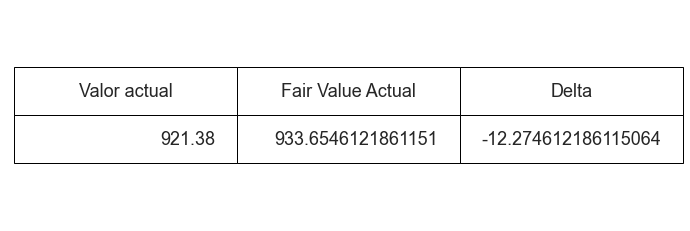

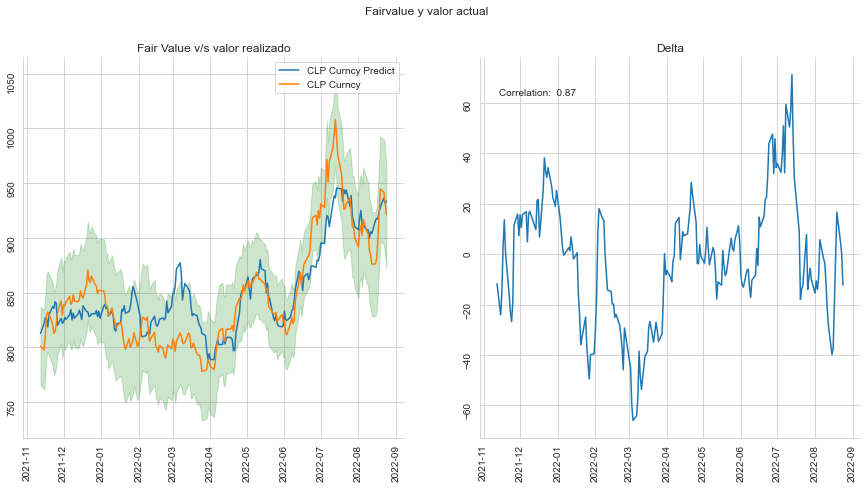

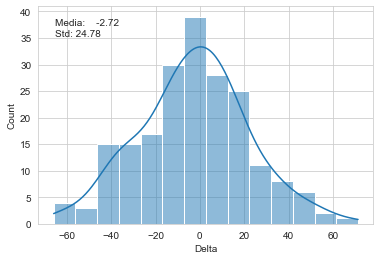

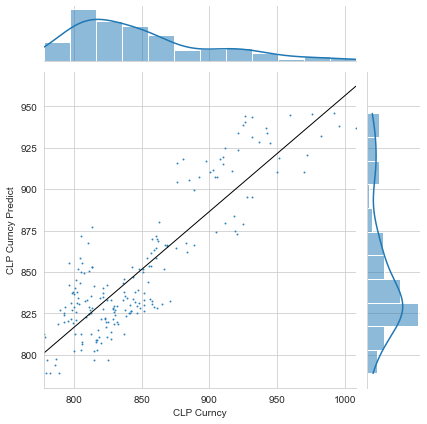

<Figure size 432x288 with 0 Axes>

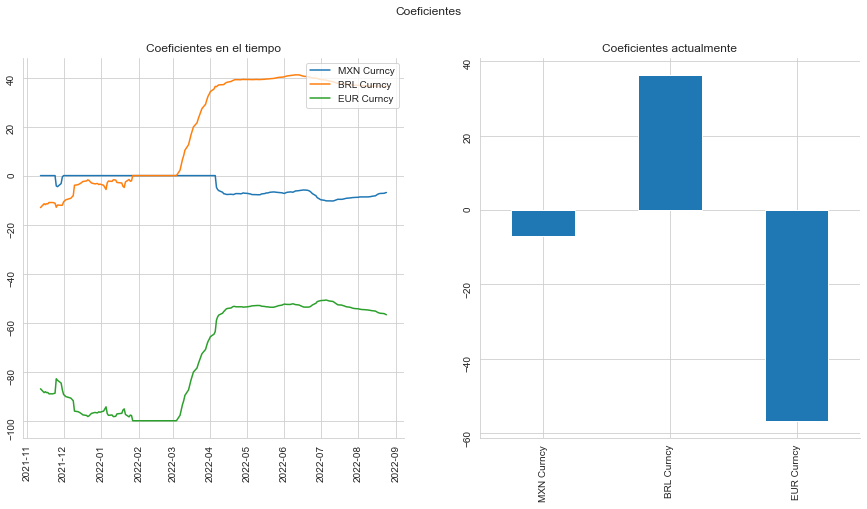

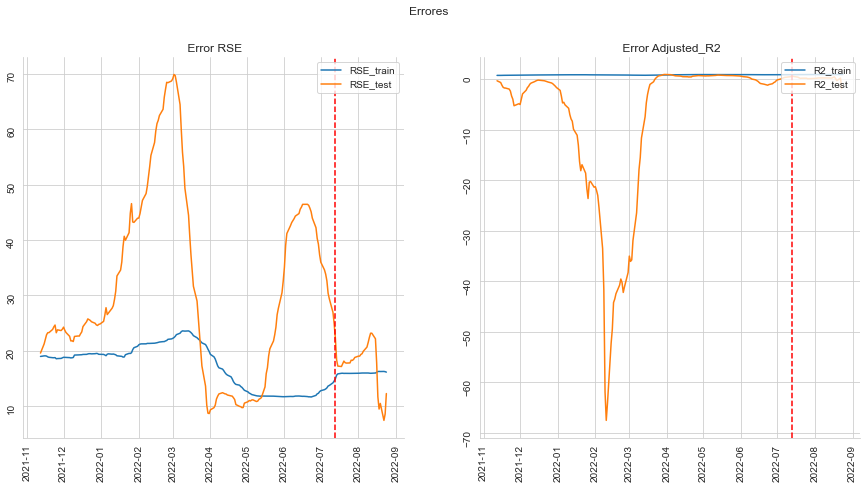

                            OLS Regression Results                            
Dep. Variable:             CLP Curncy   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     647.7
Date:                Wed, 23 Nov 2022   Prob (F-statistic):          2.02e-116
Time:                        19:45:16   Log-Likelihood:                -1050.1
No. Observations:                 250   AIC:                             2108.
Df Residuals:                     246   BIC:                             2122.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        839.6648      1.029    815.783      0.0

In [171]:
fair_value_en_ventana_tiempo=iterar_fair_value_reg_lineal(dftest,ventanadetiempo,ventana_historia_hacia_atras,modelo_de_regresion)
df_fair_values=fair_value_en_ventana_tiempo[0]
lista_coeficientes=fair_value_en_ventana_tiempo[1]
df_errores=fair_value_en_ventana_tiempo[2]
df_fair_value_valor_actual=grafico_fair_value_vs_valor_actual(dftest,df_fair_values,ventana_historia_hacia_atras,ventanadetiempo,target)
grafico_coeficientes(fair_value_en_ventana_tiempo[1])
grafico_error_RMSE_R2(dftest,df_errores,ventanadetiempo,dias_a_predecir)
print(fair_value_en_ventana_tiempo[5])

In [18]:
h_r=0
diff_lgr=df_fair_value_valor_actual.diff() #.iloc[::-1]#diff()
for i in range(0,df_fair_value_valor_actual.shape[0]):
    if diff_lgr.iloc[i,0]>0 and diff_lgr.iloc[i,1]>0:
        h_r+=1
    elif diff_lgr.iloc[i,0]<0 and diff_lgr.iloc[i,1]<0:
        h_r+=1
    else:
        h_r=h_r
print(h_r/(df_fair_value_valor_actual.shape[0]-1))    #conclusion como fair value puede funcionar pero no como predictor a mas de un dia

0.6009852216748769


## PCR función

In [295]:
def iterar_fair_value_PCR(dftest,ventanadetiempo,ventana_historia_hacia_atras):
    i=0
    lista_fair_values=[]
    df_coeficientes=pd.DataFrame()
    lista_errores_RMSE_train=[]
    lista_errores_R2_train=[]
    lista_errores_RMSE_test=[]
    lista_errores_R2_test=[]
    lista_fit_modelo=[]
    f=[]
    g=[]
    X=dftest.iloc[:,:-1]
    Y=dftest.iloc[:,-1]
    lista_features=list(X.columns.values)
    nc=2
    pca= decomposition.PCA(n_components=nc)
    pca.fit((X))
    valores=pca.transform((X))  #reglineal(x_train,x_test,y_train,y_test,modelo_de_regresion)
    X=pd.DataFrame(valores)
    while i<=ventana_historia_hacia_atras:
        if i<dias_a_predecir:
            train_test_set=train_test_split(X.iloc[::-1].iloc[:ventanadetiempo+dias_a_predecir],Y.iloc[::-1].iloc[:ventanadetiempo+dias_a_predecir],dias_a_predecir,ventanadetiempo,i)
            datos_modelo=reglineal(train_test_set[0],train_test_set[1],train_test_set[2],train_test_set[3],LinearRegression())
        else:
            train_test_set=(train_test_split(X.iloc[::-1].iloc[i-dias_a_predecir+1:ventanadetiempo+i+1],Y.iloc[::-1].iloc[i-dias_a_predecir+1:ventanadetiempo+i+1],dias_a_predecir,ventanadetiempo,i))
            datos_modelo=reglineal(train_test_set[0],train_test_set[1],train_test_set[2],train_test_set[3],LinearRegression())
        lista_fair_values.append(datos_modelo[0])
        df_coeficientes=df_coeficientes.append((pd.DataFrame(pca.components_).transpose().dot(datos_modelo[1]).transpose()))
        lista_errores_RMSE_train.append(datos_modelo[2][0])
        lista_errores_R2_train.append(datos_modelo[3][0])
        lista_errores_RMSE_test.append(datos_modelo[2][1])
        lista_errores_R2_test.append(datos_modelo[3][1])
        lista_fit_modelo.append(datos_modelo[4])       #cambiar nombres a variables 
        f.append(datos_modelo[5])
        i+=1
    df_coeficientes.columns=lista_features
    df_coeficientes=df_coeficientes.iloc[::-1]
    df_coeficientes.index=dftest.iloc[-ventana_historia_hacia_atras-1:,:].index
    df_fair_values=pd.DataFrame(lista_fair_values)
    df_fair_values.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index
    data={"RMSE_train":lista_errores_RMSE_train,"RMSE_test":lista_errores_RMSE_test,"R2_train":lista_errores_R2_train,"R2_test":lista_errores_R2_test}
    df_errores=pd.DataFrame(data=data)
    df_errores.index=dftest.iloc[::-1].iloc[0:ventana_historia_hacia_atras+1,:].index
    return(df_fair_values,df_coeficientes,df_errores,lista_fit_modelo,f)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


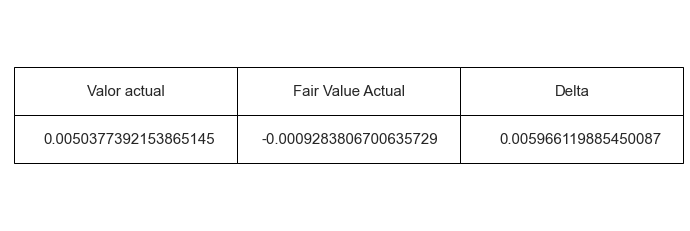

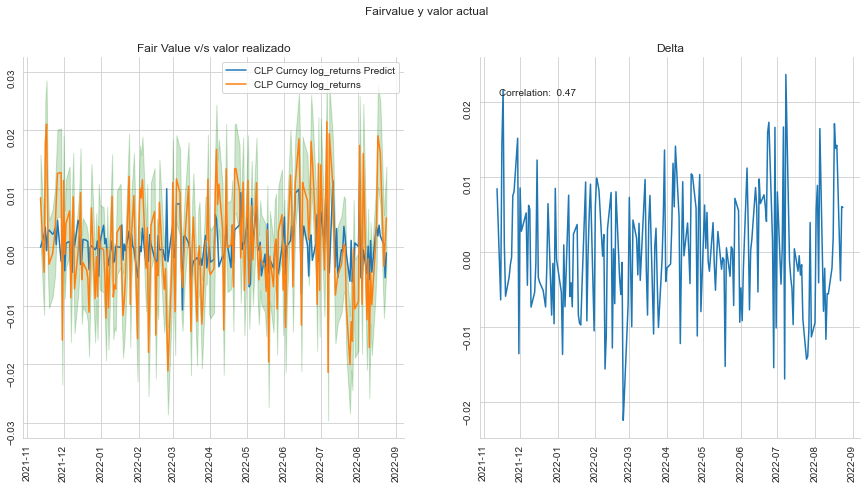

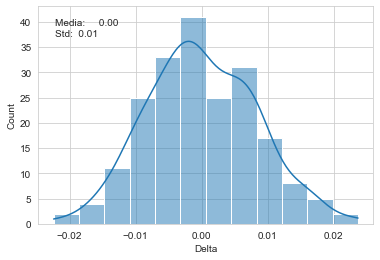

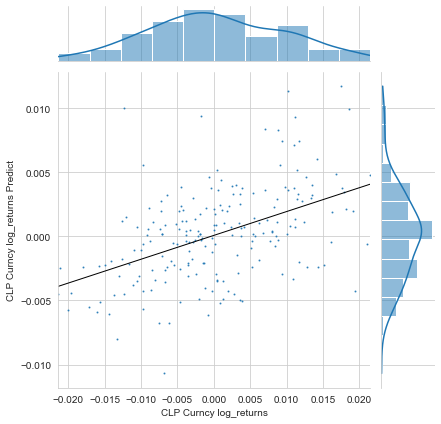

<Figure size 432x288 with 0 Axes>

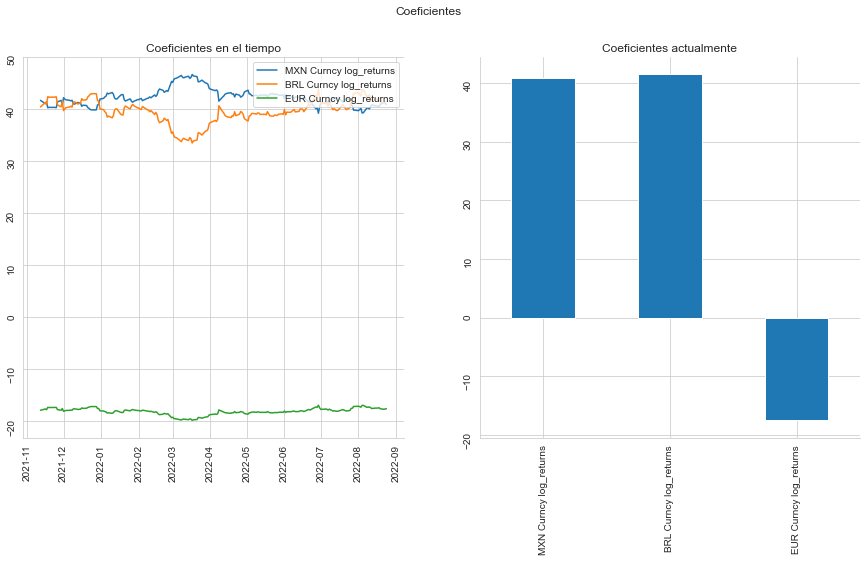

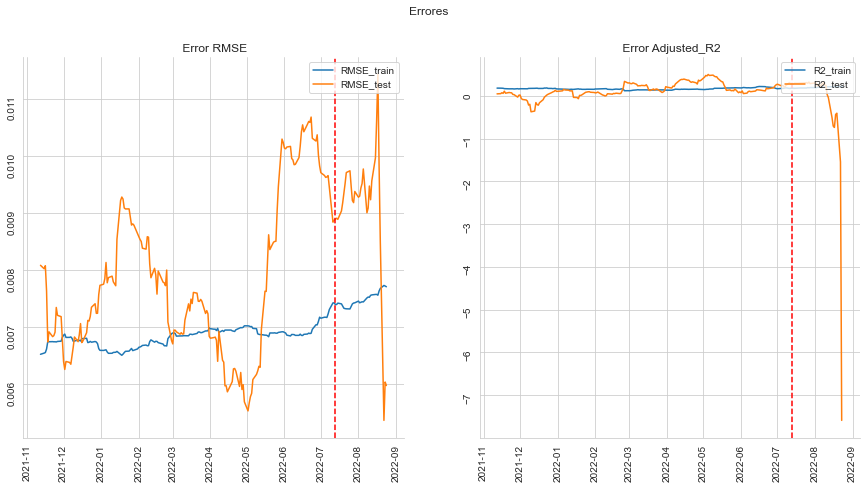

In [305]:
fair_value_en_ventana_tiempo=iterar_fair_value_PCR(dftest,ventanadetiempo,ventana_historia_hacia_atras)
df_fair_values=fair_value_en_ventana_tiempo[0]
lista_coeficientes=fair_value_en_ventana_tiempo[1]
df_errores=fair_value_en_ventana_tiempo[2]
df_fair_value_valor_actual=grafico_fair_value_vs_valor_actual(dftest,df_fair_values,ventana_historia_hacia_atras,ventanadetiempo,target)
grafico_coeficientes(fair_value_en_ventana_tiempo[1])
grafico_error_RMSE_R2(dftest,df_errores,ventanadetiempo,dias_a_predecir)